In [1]:
import argparse
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
#import importlib
import DCM_DeepCausal_CausalConv, DCM_DeepCausal_CausalConv_preTrain, DilatedCausalConv_layer, FinalRowWise_layer, GraphLearning_layer, Optim, SingularValue_layer, utils_realdata
import scipy
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.io as sio
from numpy import linalg as LA
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

class args:
    data_path = '../../ExperimentData/PAKDD_data/preprocessed/'
    #'Ja'
    data_name = 'JapaneseVowels'
    
    model = 'DCM_DeepCausal_CausalConv'
    model_preTrain = 'DCM_DeepCausal_CausalConv_preTrain'

    kernel_size = 4
    channel_multiplier = 3
    
    NumCausalLayer = 5
    reduce_dim = 50
    
    low_rank = 1
    
    clip = 1.
    epochs = 20
    epoch_preTrain = 20
    #currently, pre_win are fixed to 1 and 1. Do not change it
    batch_size = 32
    pre_win = 1
    pre_win_long = 3
    pred_start_point = 1 #(the timestamps which start to predict) 0-based index
    
    dropout = 0.1
    seed = 12345
    gpu = 0

    cuda = False
    optim = 'adam'
    lr = 0.01
    weight_decay = 0
    horizon = 1
    random_shuffle = True    
    
    cos_sim_reg_type = 'facor' #options: factor, one_matrix
    cos_lambda = 1.    

    copula = True
    normalize = True

    graph_learning = 'EF' #'options: USV, EF
    graph_batchnorm = True
    self_autoregress = False
    
np.random.seed(args.seed)
#random.seed(manualSeed)
torch.manual_seed(args.seed)
if args.cuda is True:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

Data = utils_realdata.Data_utility(args)

args.NumCluster = Data.NumCluster
args.MaxLen = Data.MaxLen

criterion = nn.MSELoss(size_average=True, reduce=False) #Take the sum, not the average
if args.cuda:
    criterion = criterion.cuda()

def cos_similarity(a, b):
    return torch.abs(torch.dot(a,b) / (torch.sqrt(torch.dot(a,a)) * torch.sqrt(torch.dot(b,b))))

def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

    
def evaluate(loader, data, model, criterion, args):
    total_loss = 0    
    total_loss_reg = 0
    n_samples = 0        
    total_time = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []
    
    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, False):                
        begin_time = time.time()
        
        [sequence, true_label, seqLen] = inputs #sequence: (variables, timestamps)      
        true_label_all.append(true_label)
        
        batch_size = len(sequence)
        
        MaxLen = sequence.shape[-1]
        
        X = []
        Y = []
        Y_long = []
        Y_long_mask = []
        for seq_i in range(batch_size):
            Len_i = seqLen[seq_i]
            X_i = sequence[seq_i,:,:Len_i-args.pre_win]
            Y_i = sequence[seq_i,:,args.pred_start_point:Len_i]            
            X_i = functional.pad(X_i, (0, (MaxLen - 1) - (Len_i - args.pre_win)), 'constant', 0)
            
            Y_i_long = torch.zeros((Data.m, MaxLen))
            Y_i_long[:, args.pred_start_point:Len_i] = Y_i
            
            Y_i_long_mask = torch.zeros((Data.m, MaxLen))
            Y_i_long_mask[:, args.pred_start_point:Len_i] = 1.0
                        
            X.append(X_i)
            Y.append(Y_i)
            Y_long.append(Y_i_long[:,1:])
            Y_long_mask.append(Y_i_long_mask[:,1:])
            # X = sequence[:,:,:-args.pre_win]  #(batch_size, variables, timestamps)
            # Y = sequence[:,:,-args.pre_win_long:]  #(batch_size, variables, timestamps)
            
        X = torch.stack(X, dim = 0)  #(batch_size, variables, timestamps)
     #   Y = torch.stack(Y, dim = 0)  #(batch_size, variables, timestamps)
        Y_long = torch.stack(Y_long, dim = 0) #(batch_size, variables, MaxLen)
        Y_long_mask = torch.stack(Y_long_mask, dim = 0) #(batch_size, variables, MaxLen)        
        
        Y_long = Y_long.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)
        Y_long_mask = Y_long_mask.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)        
                
        Y_hat_list = model(X)
        residuals = torch.zeros((batch_size, args.NumCluster))
    
        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i]*Y_long_mask, Y_long)
            
            ##multiply weights to the residuals, same as NIPS paper
            F = model.graph_net[cluster_i].single_graph_net[0].weight.transpose(1,0)
            
            tmp = functional.normalize(F, p=2, dim=0, eps=1e-10)
            tmp = torch.sum(torch.abs(tmp), dim=1)
            tmp = 1- functional.normalize(tmp, p=2, dim=0, eps=1e-10)
            F_norm = functional.normalize(tmp, p=2, dim=0, eps=1e-10)
        
            weight_tmp = F_norm.repeat(batch_size, residuals_tmp.shape[1], args.pre_win, 1)
            residuals_tmp = torch.mul(residuals_tmp, weight_tmp)
            
            residuals[:, cluster_i] = torch.sum( residuals_tmp, dim=(1,2,3))
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batch_size * Data.m * args.pre_win_long)
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        batch_loss = loss_reg        
                                            
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_time = total_time + time.time() - begin_time  
        
        n_samples += batch_size

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
        
    true_labels = np.concatenate(true_label_all, axis = 0)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors = preprocessing.scale(new_soft_vectors)
    
    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)
        return total_time, total_loss, total_loss_reg, n_samples, pred_labels, true_labels, new_soft_vectors

def train_preTrain(loader, data, model, criterion, optim, args):
    model.train()

    total_loss = 0    
    total_loss_reg = 0
    n_samples = 0        
    total_time = 0
    
    new_soft_vectors = []
    true_label_all = []    
    residuals_alldim_all = []

    for inputs in loader.get_batches(data, args.batch_size, True):                
        begin_time = time.time()
        
        [sequence, true_label, seqLen] = inputs #sequence: (batch_size, variables, timestamps)      
        true_label_all.append(true_label)
        
        batch_size = len(sequence)
        MaxLen = sequence.shape[-1]

        model.zero_grad()

        X = []
        Y = []
        Y_long = []
        Y_long_mask = []
        for seq_i in range(batch_size):
            Len_i = seqLen[seq_i]
            X_i = sequence[seq_i,:,:Len_i-args.pre_win]
            Y_i = sequence[seq_i,:,args.pred_start_point:Len_i]            
            X_i = functional.pad(X_i, (0, (MaxLen - 1) - (Len_i - args.pre_win)), 'constant', 0)
            
            Y_i_long = torch.zeros((Data.m, MaxLen))
            Y_i_long[:, args.pred_start_point:Len_i] = Y_i
            
            Y_i_long_mask = torch.zeros((Data.m, MaxLen))
            Y_i_long_mask[:, args.pred_start_point:Len_i] = 1.0
                        
            X.append(X_i)
            Y.append(Y_i)
            Y_long.append(Y_i_long[:,1:])
            Y_long_mask.append(Y_i_long_mask[:,1:])
            
        X = torch.stack(X, dim = 0)  #(batch_size, variables, timestamps)
        Y_long = torch.stack(Y_long, dim = 0) #(batch_size, variables, MaxLen)
        Y_long_mask = torch.stack(Y_long_mask, dim = 0) #(batch_size, variables, MaxLen)

        Y_long = Y_long.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)
        Y_long_mask = Y_long_mask.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)

        Y_hat = model(X)
              
        residuals_tmp = criterion(Y_hat*Y_long_mask, Y_long)
        ##multiply weights to the residuals, same as NIPS paper
        # F = model.graph_net[cluster_i].single_graph_net[0].weight.transpose(1,0)
        
        # tmp = functional.normalize(F, p=2, dim=0, eps=1e-10)
        # tmp = torch.sum(torch.abs(tmp), dim=1)
        # tmp = 1- functional.normalize(tmp, p=2, dim=0, eps=1e-10)
        # F_norm = functional.normalize(tmp, p=2, dim=0, eps=1e-10)
    
        # weight_tmp = F_norm.repeat(batch_size, residuals_tmp.shape[1], args.pre_win, 1)
        # residuals_tmp = torch.mul(residuals_tmp, weight_tmp)
        residuals = torch.sum(residuals_tmp, dim=(1,2,3))
        loss_reg = torch.sum(residuals) / (args.pre_win * batch_size * Data.m * args.pre_win_long) 

        batch_loss = loss_reg 
   #     torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        batch_loss.backward(retain_graph = True)
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    

        total_time = total_time + time.time() - begin_time  
        
        optim.step()
        n_samples += batch_size

        residuals_alldim_all.append(residuals_tmp.detach().numpy())
        new_soft_vectors.append(residuals)

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)

    true_labels = np.concatenate(true_label_all, axis = 0)
    residuals_alldim_all = np.concatenate(residuals_alldim_all, axis = 0)

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors_norm = preprocessing.scale(new_soft_vectors)

    return total_time, total_loss, total_loss_reg, n_samples, true_labels, new_soft_vectors_norm, residuals_alldim_all

def train(loader, data, model, criterion, optim, args):
    model.train()

    total_loss = 0    
    total_loss_reg = 0
    total_loss_cos = 0
    n_samples = 0        
    total_time = 0
    
    count = 0
    
    pred_labels = []
    new_soft_vectors = []
    true_label_all = []    

    residuals_alldim_all = [ [] for _ in range(args.NumCluster) ]

    for inputs in loader.get_batches(data, args.batch_size, True):                
        begin_time = time.time()
        
        [sequence, true_label, seqLen] = inputs #sequence: (batch_size, variables, timestamps)      
        true_label_all.append(true_label)
        
        batch_size = len(sequence)
        
        model.zero_grad()
        
        MaxLen = sequence.shape[-1]
        
        X = []
        Y = []
        Y_long = []
        Y_long_mask = []
        for seq_i in range(batch_size):
            Len_i = seqLen[seq_i]
            X_i = sequence[seq_i,:,:Len_i-args.pre_win]
            Y_i = sequence[seq_i,:,args.pred_start_point:Len_i]            
            X_i = functional.pad(X_i, (0, (MaxLen - 1) - (Len_i - args.pre_win)), 'constant', 0)
            
            Y_i_long = torch.zeros((Data.m, MaxLen))
            Y_i_long[:, args.pred_start_point:Len_i] = Y_i
            
            Y_i_long_mask = torch.zeros((Data.m, MaxLen))
            Y_i_long_mask[:, args.pred_start_point:Len_i] = 1.0
                        
            X.append(X_i)
            Y.append(Y_i)
            Y_long.append(Y_i_long[:,1:])
            Y_long_mask.append(Y_i_long_mask[:,1:])
            # X = sequence[:,:,:-args.pre_win]  #(batch_size, variables, timestamps)
            # Y = sequence[:,:,-args.pre_win_long:]  #(batch_size, variables, timestamps)
            
        X = torch.stack(X, dim = 0)  #(batch_size, variables, timestamps)
     #   Y = torch.stack(Y, dim = 0)  #(batch_size, variables, timestamps)
        Y_long = torch.stack(Y_long, dim = 0) #(batch_size, variables, MaxLen)
        Y_long_mask = torch.stack(Y_long_mask, dim = 0) #(batch_size, variables, MaxLen)

     #   Y = Y.transpose(1,2).unsqueeze(2) #(batch_size, pre_win_long, pre_win, m)
        Y_long = Y_long.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)
        Y_long_mask = Y_long_mask.transpose(1,2).unsqueeze(2) #(batch_size, timestamps, pre_win, m)

        Y_hat_list = model(X)
        residuals = torch.zeros((batch_size, args.NumCluster))
              
        for cluster_i in range(args.NumCluster):
            residuals_tmp = criterion(Y_hat_list[cluster_i]*Y_long_mask, Y_long)

            ##multiply weights to the residuals, same as NIPS paper
            # F = model.graph_net[cluster_i].single_graph_net[0].weight.transpose(1,0)
            
            # tmp = functional.normalize(F, p=2, dim=0, eps=1e-10)
            # tmp = torch.sum(torch.abs(tmp), dim=1)
            # tmp = 1- functional.normalize(tmp, p=2, dim=0, eps=1e-10)
            # F_norm = functional.normalize(tmp, p=2, dim=0, eps=1e-10)
        
            # weight_tmp = F_norm.repeat(batch_size, residuals_tmp.shape[1], args.pre_win, 1)
            # residuals_tmp = torch.mul(residuals_tmp, weight_tmp)

            residuals[:, cluster_i] = torch.sum(residuals_tmp, dim=(1,2,3))
            residuals_alldim_all[cluster_i].append(residuals_tmp.detach().numpy())

        new_soft_vectors.append(residuals)
        loss_reg = torch.sum(torch.min(residuals, dim=1)[0]) / (args.pre_win * batch_size * Data.m * args.pre_win_long) 
        pred_labels.append(torch.min(residuals, dim=1)[1])
        
        Cos_loss = torch.tensor(0.0)
        graph_tensor_list = []
        
        if args.cos_sim_reg_type == 'factor':
            for i_i in range(args.NumCluster):
                graph_tensor_list_clst = []
                
                if args.graph_learning == 'USV':
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[0].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[1].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[2].weight.flatten())
                elif args.graph_learning == 'EF':
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[0].weight.flatten())
                    graph_tensor_list_clst.append(model.graph_net[i_i].single_graph_net[1].weight.flatten())                    
                
                graph_tensor_clst = torch.cat(graph_tensor_list_clst)
                graph_tensor_list.append(graph_tensor_clst)

        elif args.cos_sim_reg_type == 'one_matrix':
            graph_tensor_list = []
            graph_list = model.predict_relationship_inside()               
            for clust_i in range(args.NumCluster):
                graph_tensor_list.append(graph_list[clust_i].flatten())
        
        if len(graph_tensor_list) > 0:
            for i_i in range(args.NumCluster - 1):
                for j_i in range(i_i+1, args.NumCluster):
                    Cos_loss += cos_similarity(graph_tensor_list[i_i], graph_tensor_list[j_i])           

        batch_loss = loss_reg + args.cos_lambda*Cos_loss        
        
   #     torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
                                    
        batch_loss.backward(retain_graph = True)
        total_loss += batch_loss.data.item()
        total_loss_reg += loss_reg.data.item()    
        total_loss_cos += Cos_loss.data.item()    

        total_time = total_time + time.time() - begin_time  
        
        optim.step()
        n_samples += batch_size
        count += 1

    total_loss /= (n_samples)
    total_loss_reg /= (n_samples)
    total_loss_cos /= count

    true_labels = np.concatenate(true_label_all, axis = 0)
    pred_labels = (torch.cat(pred_labels, dim = 0)).detach().numpy()

    for clust_i in range(args.NumCluster):
        residuals_alldim_all[clust_i] = np.concatenate(residuals_alldim_all[clust_i], axis = 0)

    new_soft_vectors = (torch.cat(new_soft_vectors, dim = 0)).detach().numpy()
    new_soft_vectors_norm = preprocessing.scale(new_soft_vectors)

    return total_time, total_loss, total_loss_reg, total_loss_cos, n_samples, pred_labels, true_labels, new_soft_vectors_norm, residuals_alldim_all

###############PreTraining##############################
print('buliding preTrain odel')
model_preTrain = eval(args.model_preTrain).Model_preTrain(args, Data)
if args.cuda:
    model_preTrain.cuda()
nParams = sum([p.nelement() for p in model_preTrain.parameters()])
print('* number of parameters for preTrain model: %d' % nParams)
optim_preTrain = Optim.Optim(model_preTrain.parameters(), args.optim, args.lr, args.clip, weight_decay = args.weight_decay)

total_preTrain_loss_set1 = []
total_preTrain_loss_reg_set1 = []
total_preTrain_loss_set2 = []
total_preTrain_loss_reg_set2 = []

print("begin preTraining")
for epoch in range(0, args.epoch_preTrain):
    epoch_time, total_loss1, total_loss_reg1, n_samples1, true_labels1, residuals1, residuals_alldim1 = train_preTrain(Data, Data.train, model_preTrain, criterion, optim_preTrain, args)

    total_preTrain_loss_set1.append(total_loss1)
    total_preTrain_loss_reg_set1.append(total_loss_reg1)

    print('Epoch {:3d}|time:{:5.2f}s|total_loss_train:{:5.4f}|regression_loss_train:{:5.4f}|'.format(epoch, epoch_time, total_loss1, total_loss_reg1))

buliding preTrain odel
* number of parameters for preTrain model: 108147
begin preTraining
Epoch   0|time:16.64s|total_loss_train:0.1198|regression_loss_train:0.1198|
Epoch   1|time:14.61s|total_loss_train:0.0859|regression_loss_train:0.0859|
Epoch   2|time:14.41s|total_loss_train:0.0727|regression_loss_train:0.0727|
Epoch   3|time:14.81s|total_loss_train:0.0680|regression_loss_train:0.0680|
Epoch   4|time:15.12s|total_loss_train:0.0648|regression_loss_train:0.0648|
Epoch   5|time:14.97s|total_loss_train:0.0625|regression_loss_train:0.0625|
Epoch   6|time:15.22s|total_loss_train:0.0617|regression_loss_train:0.0617|
Epoch   7|time:16.59s|total_loss_train:0.0611|regression_loss_train:0.0611|
Epoch   8|time:14.89s|total_loss_train:0.0599|regression_loss_train:0.0599|
Epoch   9|time:14.45s|total_loss_train:0.0589|regression_loss_train:0.0589|
Epoch  10|time:14.46s|total_loss_train:0.0586|regression_loss_train:0.0586|
Epoch  11|time:14.47s|total_loss_train:0.0590|regression_loss_train:0.059

In [2]:
model_preTrain

Model_preTrain(
  (CausalLayerList): ModuleList(
    (0): DilatedCausalConv(
      (CausalLayer): Conv1d(1, 3, kernel_size=(4,), stride=(1,), padding=(3,))
    )
    (1): DilatedCausalConv(
      (CausalLayer): Conv1d(3, 9, kernel_size=(4,), stride=(1,), padding=(6,), dilation=(2,))
    )
    (2): DilatedCausalConv(
      (CausalLayer): Conv1d(9, 27, kernel_size=(4,), stride=(1,), padding=(12,), dilation=(4,))
    )
    (3): DilatedCausalConv(
      (CausalLayer): Conv1d(27, 81, kernel_size=(4,), stride=(1,), padding=(24,), dilation=(8,))
    )
    (4): DilatedCausalConv(
      (CausalLayer): Conv1d(81, 243, kernel_size=(4,), stride=(1,), padding=(48,), dilation=(16,))
    )
  )
  (graph_net): LowRankGraph_EF(
    (single_graph_net): ModuleList(
      (0): Linear(in_features=12, out_features=1, bias=False)
      (1): Linear(in_features=1, out_features=12, bias=False)
    )
  )
  (compress_net): ModuleList(
    (0): Linear(in_features=363, out_features=50, bias=True)
    (1): FR_Model()

In [15]:
torch.save(model.CausalLayerList.state_dict(), )

OrderedDict([('0.CausalLayer.bias', tensor([ 0.4057, -0.2369, -0.2964])),
             ('0.CausalLayer.weight_g',
              tensor([[[0.7773]],
              
                      [[0.5570]],
              
                      [[0.4489]]])),
             ('0.CausalLayer.weight_v',
              tensor([[[ 0.4917,  0.3696,  0.4824, -0.0489]],
              
                      [[-0.4068, -0.3315, -0.1425,  0.0577]],
              
                      [[-0.1524, -0.2781, -0.0306,  0.3253]]])),
             ('1.CausalLayer.bias',
              tensor([ 0.1081, -0.2952, -0.2016,  0.1619, -0.2612,  0.1332,  0.0233,  0.2539,
                       0.1088])),
             ('1.CausalLayer.weight_g',
              tensor([[[0.5329]],
              
                      [[0.5066]],
              
                      [[0.5410]],
              
                      [[0.6288]],
              
                      [[0.4760]],
              
                      [[0.6012]],
         

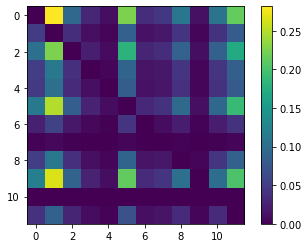

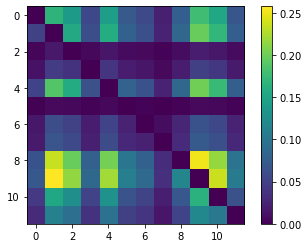

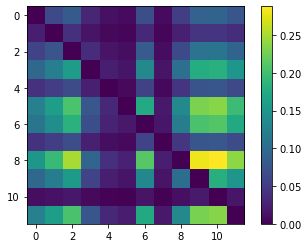

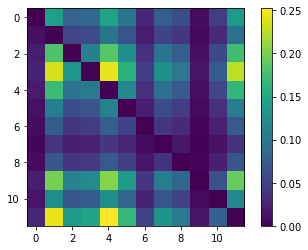

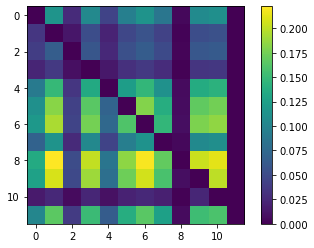

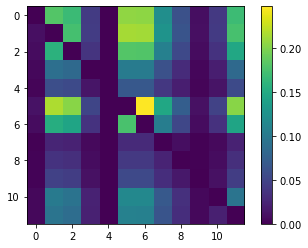

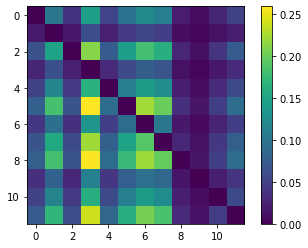

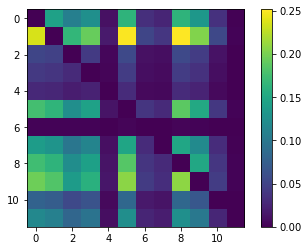

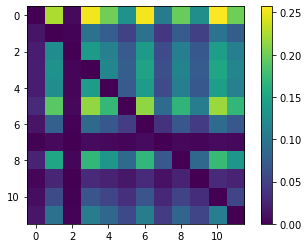

In [6]:
from numpy import linalg as LA
CGraph_list = model.predict_relationship_inside()
for cluster_i in range(len(CGraph_list)):
    CGraph_vector = CGraph_list[cluster_i].reshape(model.m*model.m).detach().numpy()
    plt.figure(cluster_i)
    plt.imshow(CGraph_vector.reshape(Data.m, Data.m))
    plt.colorbar()
    norm_l2 = LA.norm(CGraph_vector)

Text(0, 0.5, 'loss')

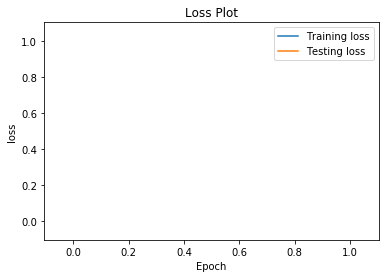

In [7]:
plt.plot(total_loss_set1)
plt.plot(total_loss_set2)
plt.legend(('Training loss', 'Testing loss'))
plt.title("Loss Plot")
plt.xlabel('Epoch')
plt.ylabel('loss')

In [ ]:
residuals = residuals_set2[0]
Max = np.max(np.array(residuals))
for col_i in range(args.NumCluster):
    plt.figure(0, figsize=(30, 30))
    figure_number = int('3'+ '3' + str(col_i+1))
    plt.subplot(figure_number)
    plt.title("Residual Matrix Column " + str(col_i))
    plt.scatter(np.array(range(len(residuals))), residuals[:,col_i], c = pred_labels2, s = 10)
    plt.ylim(0, Max)
    plt.xlabel('Examples')
    plt.ylabel('Residuals')

In [ ]:
residuals = residuals_set2[-1]
Max = np.max(np.array(residuals))
for col_i in range(args.NumCluster):
    plt.figure(0, figsize=(30, 30))
    figure_number = int('3'+ '3' + str(col_i+1))
    plt.subplot(figure_number)
    plt.title("Residual Matrix Column " + str(col_i))
    plt.scatter(np.array(range(len(residuals))), residuals[:,col_i], c = pred_labels2, s = 10)
    plt.ylim(0, Max)
    plt.xlabel('Examples')
    plt.ylabel('Residuals')

In [ ]:
residuals = residuals_set2[0]
plt.figure(0, figsize=(30, 30))
plt.title("Cluster " + str(cluster_i))
cluster_i == 2
for col_i in range(args.NumCluster):
    figure_number = int('3'+ '3' + str(col_i+1))
    plt.subplot(figure_number)
    example = np.where(true_labels1==cluster_i)[0]
    plt.scatter(example, residuals[example, col_i], c = pred_labels2[example], s = 10)
    plt.ylim(0, Max)

In [ ]:
import numpy.linalg as LA

In [ ]:
import numpy.linalg as LA
for cluster_i in range(args.NumCluster):
    E = model.graph_net[cluster_i].single_graph_net[0].weight.detach().numpy()
    F = model.graph_net[cluster_i].single_graph_net[1].weight.detach().numpy().transpose(1,0)
    E_norm = LA.norm(E, axis = 1)
    F_norm = LA.norm(F, axis = 1)
    print('for cluster_i ' + str(cluster_i) + ' E_norm' + ' F_norm')
    print(E_norm)
    print(F_norm)

In [ ]:
E.shape